# RWGS Modeling with Gradient Boosting Regression

This notebook trains a multi‐output Gradient Boosting regressor to predict CO₂ conversion **X(CO₂)** and CO selectivity **S(CO)** from reactor conditions **Tout**, **pset**, **H₂/CO₂** and **GHSV**.

---

In [11]:

# In[1]: Imports and Data Loading

import numpy as np
import pandas as pd
from io import StringIO

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

import shap

# Raw CSV data
csv_data = """\
Tout,pset,H2toCO2,GHSV,xH2,xCH4,xCO,xCO2,XCO2,SCO
981.80,6.00,2.50,8000,63.00,-0.04,28.30,8.38,85.93,98.00
980.00,6.00,2.50,,63.20,0.08,28.50,8.26,86.61,99.48
952.70,6.00,2.50,8000,63.00,0.00,27.70,8.79,84.53,97.12
950.00,6.00,2.50,,63.30,0.14,27.90,8.63,85.23,99.27
949.80,6.00,1.30,8000,41.00,-0.04,36.70,21.90,98.91,6.49
950.00,6.00,1.30,,40.60,0.03,36.60,22.80,98.80,6.30
949.10,6.00,1.30,8000,41.10,-0.04,36.80,21.80,98.91,6.62
950.00,6.00,1.30,,40.60,0.03,36.60,22.80,98.80,6.30
571.22,1.16,3.00,8000,64.40,10.68,8.51,17.19,50.83,42.20
595.01,1.27,3.00,20000,67.00,8.03,10.31,15.45,52.70,52.08
581.07,6.06,3.00,8000,49.22,26.32,4.78,21.11,58.92,14.87
621.86,6.01,3.00,20000,56.70,18.39,7.73,17.96,57.31,28.38
582.21,7.99,3.00,8000,46.27,29.35,4.29,21.59,60.47,12.38
628.62,7.98,3.00,20000,54.75,20.39,7.37,18.29,58.41,25.45
657.29,1.16,3.00,8000,71.09,3.22,14.05,12.17,56.33,74.41
663.16,1.27,3.00,20000,71.10,3.44,13.95,12.09,57.07,71.79
666.81,6.00,3.00,8000,60.61,13.92,9.87,15.98,57.09,40.26
688.14,5.98,3.00,20000,63.48,11.02,11.53,14.24,58.45,48.65
668.38,8.03,3.00,8000,58.28,16.34,9.17,16.65,57.92,34.93
693.78,7.94,3.00,20000,61.84,12.68,11.12,14.62,59.07,44.70
753.01,1.19,3.00,8000,73.47,0.36,17.72,8.91,63.89,86.42
750.11,1.27,3.00,20000,73.45,0.58,17.41,9.07,63.78,84.06
755.83,5.98,3.00,8000,68.77,5.12,15.43,10.81,61.92,69.91
761.19,5.97,3.00,20000,69.08,4.89,15.63,10.59,62.51,70.14
849.99,1.26,3.00,8000,73.32,0.04,19.67,7.36,68.73,88.85
849.68,1.28,3.00,20000,73.46,0.06,19.56,7.37,68.87,87.52
850.43,5.98,3.00,8000,72.40,0.95,19.23,7.69,68.15,85.95
850.68,6.02,3.00,20000,72.41,1.07,19.14,7.70,68.39,84.44
946.43,1.21,3.00,8000,73.00,0.00,21.06,6.27,72.27,89.77
947.99,1.28,3.00,20000,73.14,0.00,21.02,6.23,72.54,88.60
947.15,5.92,3.00,8000,72.83,0.15,21.01,6.31,72.17,89.49
948.54,5.99,3.00,20000,72.99,0.17,20.93,6.27,72.46,87.95
"""
df = pd.read_csv(StringIO(csv_data))
df['GHSV'] = df['GHSV'].fillna(df['GHSV'].median())
print("Data shape:", df.shape)


Data shape: (32, 10)


In [12]:
# In[2]: Feature / Target Split and Train/Test Split

features = ['Tout','pset','H2toCO2','GHSV']
targets  = ['XCO2','SCO']

X = df[features].values
y = df[targets].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")


Train size: 25, Test size: 7


In [13]:
# In[3]: Train Multi-Output Gradient Boosting with Early Stopping

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

# Base regressor with early stopping
base_gb = GradientBoostingRegressor(
    n_estimators=500,           # maximum trees
    learning_rate=0.05,         # step size shrinkage
    max_depth=4,                # tree depth
    random_state=42,
    validation_fraction=0.2,    # fraction of train used for validation
    n_iter_no_change=20,        # stop if no improvement
    tol=1e-4                    # minimum improvement threshold
)

# Wrap in MultiOutput for two targets
model_gb = MultiOutputRegressor(base_gb)

# Fit
model_gb.fit(X_train, y_train)

# Display how many trees were actually used (early stopping)
print(f"Trees used for X(CO₂): {model_gb.estimators_[0].n_estimators_}")
print(f"Trees used for S(CO) : {model_gb.estimators_[1].n_estimators_}")



Trees used for X(CO₂): 226
Trees used for S(CO) : 109


Train RMSE: 1.21
Test RMSE : 5.46


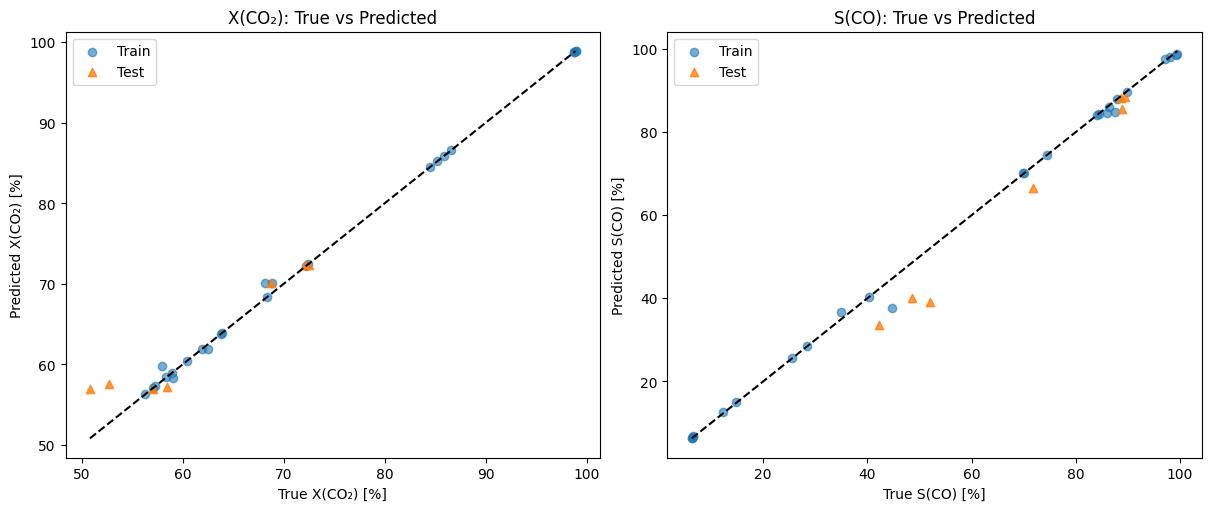

In [14]:
# In[4]: Evaluate & Plot Predictions

# Predict
y_train_pred = model_gb.predict(X_train)
y_test_pred  = model_gb.predict(X_test)

# Compute RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test  = np.sqrt(mean_squared_error(y_test,  y_test_pred))
print(f"Train RMSE: {rmse_train:.2f}")
print(f"Test RMSE : {rmse_test:.2f}")

# Plot true vs. predicted
fig, axes = plt.subplots(1, 2, figsize=(12,5), constrained_layout=True)
titles = ['X(CO₂)', 'S(CO)']

for i, ax in enumerate(axes):
    ax.scatter(y_train[:,i], y_train_pred[:,i], label='Train', alpha=0.6)
    ax.scatter(y_test[:,i],  y_test_pred[:,i],  label='Test',  alpha=0.8, marker='^')
    mn, mx = y[:,i].min(), y[:,i].max()
    ax.plot([mn,mx], [mn,mx], 'k--')
    ax.set_title(f"{titles[i]}: True vs Predicted")
    ax.set_xlabel(f"True {titles[i]} [%]")
    ax.set_ylabel(f"Predicted {titles[i]} [%]")
    ax.legend()
plt.show()


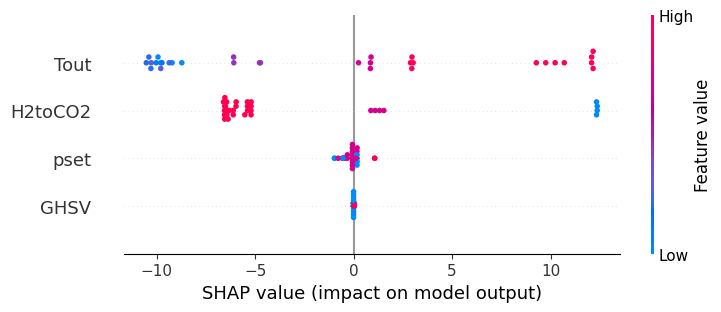

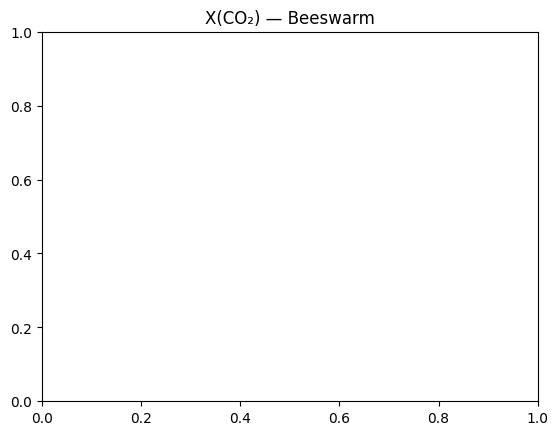

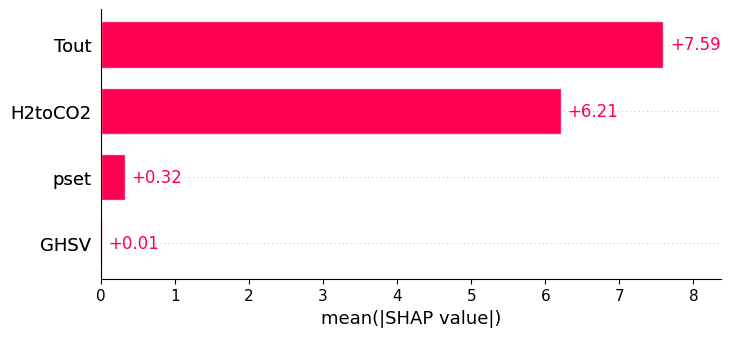

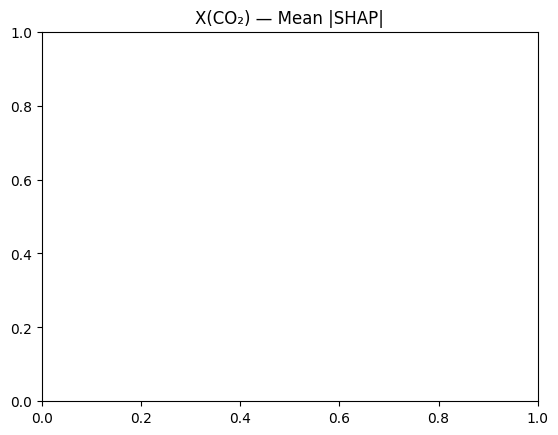

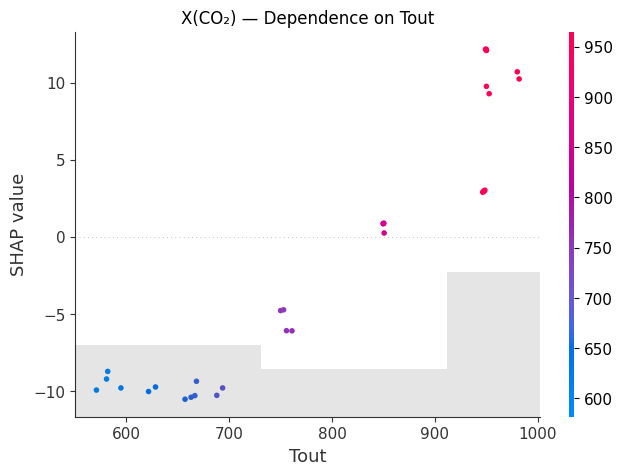

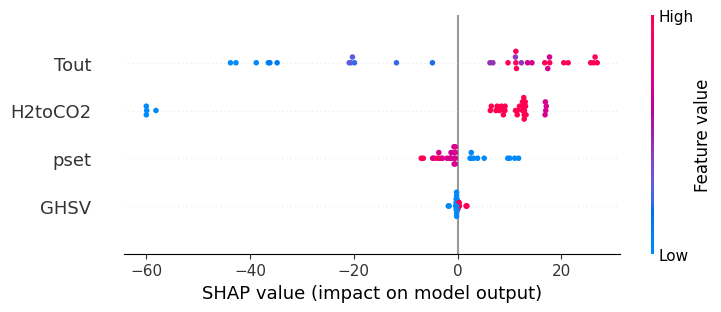

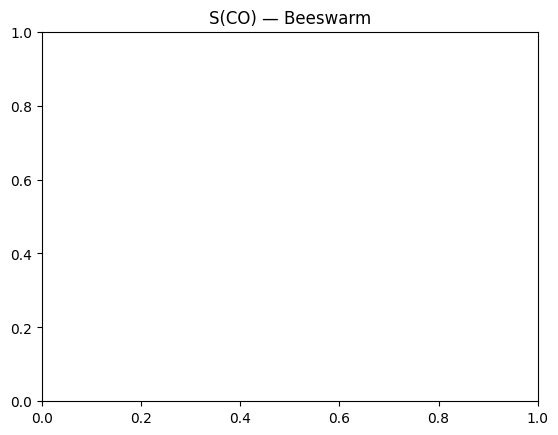

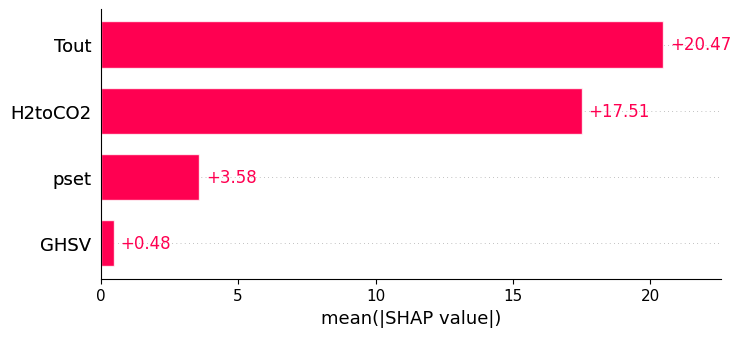

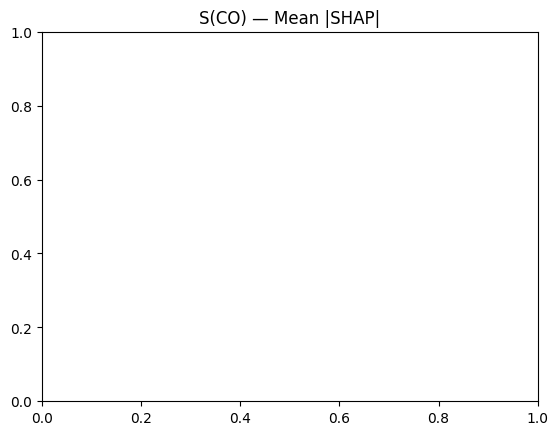

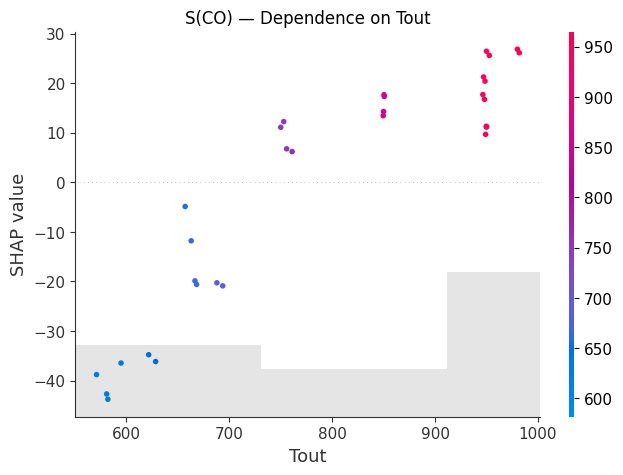

In [15]:
# In[5]: Enhanced SHAP Interpretation for Gradient Boosting

import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1) Combine train+test features
X_all = np.vstack([X_train, X_test])
df_all = pd.DataFrame(X_all, columns=features)

def shap_analysis_for_estimator(est, title_prefix):
    # If wrapped in MultiOutput, get the underlying estimator
    tree = getattr(est, 'estimator', est)
    
    # 2) Compute SHAP values
    explainer = shap.TreeExplainer(tree)
    shap_vals = explainer.shap_values(df_all)
    
    # 3) Create Explanation object
    expl = shap.Explanation(
        values=shap_vals,
        data=df_all.values,
        feature_names=features
    )
    
    # 4a) Beeswarm plot
    shap.plots.beeswarm(expl)
    plt.title(f'{title_prefix} — Beeswarm')
    plt.show()
    
    # 4b) Bar plot of mean |SHAP|
    shap.plots.bar(expl)
    plt.title(f'{title_prefix} — Mean |SHAP|')
    plt.show()
    
    # 4c) Dependence on top feature
    mean_abs = np.abs(shap_vals).mean(axis=0)
    top_idx = mean_abs.argmax()
    top_feat = features[top_idx]
    
    shap.plots.scatter(
        expl[:, top_idx],
        color=expl.data[:, top_idx],
        show=False
    )
    plt.title(f'{title_prefix} — Dependence on {top_feat}')
    plt.xlabel(top_feat)
    plt.ylabel('SHAP value')
    plt.show()

# SHAP for X(CO₂)
shap_analysis_for_estimator(model_gb.estimators_[0], 'X(CO₂)')

# SHAP for S(CO)
shap_analysis_for_estimator(model_gb.estimators_[1], 'S(CO)')



---
**Notes:**  
- We wrap `GradientBoostingRegressor` in `MultiOutputRegressor` to predict both targets.  
- SHAP `TreeExplainer` works directly on each individual estimator.  
- Adjust `n_estimators`, `learning_rate`, and `max_depth` as needed.  
